In [ ]:
!pip install gymnasium
!pip install pygame

# Carga y exploración de un entorno de Gymnasium

In [42]:
import gymnasium as gym
import numpy as np
import time
from IPython.display import clear_output, display, HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random
from itertools import product
from concurrent.futures import ProcessPoolExecutor, as_completed
import imageio
from IPython.display import HTML
import pickle

SEED = 42

# -------------------- VISUALIZACIÓN DE RESULTADOS --------------------

def graficar_recompensas(agente):
    """Grafica la recompensa media acumulada por episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.stats)
    plt.title('Recompensa media acumulada')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa media')
    plt.grid(True)
    plt.show()

def graficar_longitud_episodios(agente):
    """Grafica la longitud de cada episodio."""
    plt.figure(figsize=(6, 3))
    plt.plot(agente.episode_lengths)
    plt.title("Longitud de episodios")
    plt.xlabel("Episodio")
    plt.ylabel("Pasos")
    plt.grid(True)
    plt.show()

def mostrar_resultados_agente_continuo(agente):
    """Muestra gráficos de rendimiento en entornos continuos."""
    graficar_recompensas(agente)
    graficar_longitud_episodios(agente)

# -------------------- EJECUCIÓN DE UN EPISODIO --------------------

def ejecutar_episodio_y_mostrar(agente, render=False):
    """Ejecuta un episodio con la política aprendida y muestra la evolución de la posición."""
    env = agente.env
    state, _ = env.reset()
    done = False
    total_reward = 0
    posiciones = []

    while not done:
        if render:
            env.render()
        posiciones.append(state[0])  # Guardamos la posición del coche
        action = agente.seleccionar_accion(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    env.close()
    
    # Mostrar gráfico de posiciones
    plt.figure(figsize=(6, 3))
    plt.plot(posiciones)
    plt.title("Evolución de la posición del coche")
    plt.xlabel("Paso del episodio")
    plt.ylabel("Posición")
    plt.grid(True)
    plt.show()
    
    print(f"Recompensa total obtenida: {total_reward:.2f}")

# -------------------- EVALUACIÓN DE LA POLÍTICA --------------------

def evaluar_politica(agente, num_episodios=100):
    """Evalúa la política del agente ejecutando múltiples episodios y muestra estadísticas."""

    env = agente.env
    recompensas = []
    longitudes = []
    semillas_fallidas = []

    for i in range(num_episodios):
        random.seed(i)
        np.random.seed(i)
        env.action_space.seed(i)
        state, _ = env.reset(seed=i)
        done = False
        total_reward = 0
        posiciones = []
        pasos = 0

        terminated = False
        truncated = False
        
        while not done:
            posiciones.append(state[0])
            action = agente.seleccionar_accion_greedy(state)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            pasos += 1
            
            if truncated:
                semillas_fallidas.append(i)
                
        recompensas.append(total_reward)
        longitudes.append(pasos)
        env.close()

    # Resumen estadístico
    print("📊 Resultados de evaluación:")
    print(f"  Episodios evaluados: {num_episodios}")
    print(f"  Recompensa media:    {np.mean(recompensas):.2f} ± {np.std(recompensas):.2f}")
    print(f"  Recompensa min/max:  {np.max(recompensas):.2f} / {np.min(recompensas):.2f}")

    print(f"  Episodios exitosos:  {num_episodios - len(semillas_fallidas)}")
    print(f"  Episodios fallidos:  {len(semillas_fallidas)}")
    print(f"  Semillas fallidas: {semillas_fallidas}")


# Objeto AgenteSARSA-SemiGradiente

In [55]:
# Tile coder para MountainCar
class TileCoder:
    def __init__(self, low, high, bins=(10, 10), num_tilings=8, offsets=None):
        self.low = np.array(low)
        self.high = np.array(high)
        self.bins = np.array(bins)
        self.num_tilings = num_tilings
        self.tile_width = (self.high - self.low) / (self.bins - 1)
        self.tiles_per_tiling = int(np.prod(self.bins))

        if offsets is not None:
            self.offsets = offsets
        else:
            # Offsets regulares para reproducibilidad
            self.offsets = [
                (np.arange(len(self.low)) * i * self.tile_width / self.num_tilings)
                for i in range(num_tilings)
            ]

    def get_feature_indices(self, state):
        indices = []
        for i, offset in enumerate(self.offsets):
            shifted = state + offset
            idx = ((shifted - self.low) / self.tile_width).astype(int)
            idx = np.clip(idx, 0, self.bins - 1)
            tile_index = np.ravel_multi_index(idx, self.bins)
            indices.append(i * self.tiles_per_tiling + tile_index)
        return indices


class AgenteSARSATileCoding:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=1.0, decay=True, bins=(8, 8), num_tilings=8, offsets=None):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay

        self.nA = env.action_space.n
        self.tile_coder = TileCoder(env.observation_space.low, env.observation_space.high, bins, num_tilings, offsets)
        self.d = self.tile_coder.tiles_per_tiling * num_tilings
        self.theta = np.zeros((self.nA, self.d))
        self.stats = []
        self.episode_lengths = []

    def guardar_agente(self, ruta_archivo="agente_sarsa_tilecoding.pkl"):
        datos = {
            "alpha": self.alpha,
            "gamma": self.gamma,
            "epsilon": self.epsilon,
            "decay": self.decay,
            "bins": self.tile_coder.bins,
            "num_tilings": self.tile_coder.num_tilings,
            "theta": self.theta,
            "stats": self.stats,
            "episode_lengths": self.episode_lengths,
            "low": self.tile_coder.low,
            "high": self.tile_coder.high,
            "offsets": self.tile_coder.offsets
        }
        with open(ruta_archivo, "wb") as f:
            pickle.dump(datos, f)

    @staticmethod
    def cargar_agente(ruta_archivo="agente_sarsa_tilecoding.pkl"):
        with open(ruta_archivo, "rb") as f:
            datos = pickle.load(f)

        env = gym.make("MountainCar-v0")
        env.reset(seed=42)

        agente = AgenteSARSATileCoding(
            env,
            alpha=datos["alpha"],
            gamma=datos["gamma"],
            epsilon=datos["epsilon"],
            decay=datos["decay"],
            bins=tuple(datos["bins"]),
            num_tilings=datos["num_tilings"],
            offsets=datos["offsets"]
        )

        agente.theta = datos["theta"]
        agente.stats = datos["stats"]
        agente.episode_lengths = datos["episode_lengths"]

        return agente

    def _Q(self, state, action):
        indices = self.tile_coder.get_feature_indices(state)
        return np.sum(self.theta[action, indices])

    def seleccionar_accion(self, state):
        policy = self._epsilon_soft_policy(state)
        return np.random.choice(np.arange(self.nA), p=policy)

    def seleccionar_accion_greedy(self, state):
        q_values = [self._Q(state, a) for a in range(self.nA)]
        return np.argmax(q_values)

    def _epsilon_soft_policy(self, state):
        q_values = np.array([self._Q(state, a) for a in range(self.nA)])
        policy = np.ones(self.nA) * self.epsilon / self.nA
        best_action = np.argmax(q_values)
        policy[best_action] += 1.0 - self.epsilon
        return policy

    def entrenar(self, num_episodes=5000, mostrar_barra=True):
        from tqdm import tqdm
        acumulador_recompensas = 0.0

        for t in tqdm(range(num_episodes), disable=not mostrar_barra):
            if self.decay:
                self.epsilon = max(0.05, 1000.0 / (t + 1))

            state, _ = self.env.reset(seed=42)
            action = self.seleccionar_accion(state)
            done = False
            total_reward = 0
            pasos = 0

            while not done:
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_action = self.seleccionar_accion(next_state)

                indices = self.tile_coder.get_feature_indices(state)
                q_current = np.sum(self.theta[action, indices])
                q_next = self._Q(next_state, next_action) if not done else 0.0
                delta = reward + self.gamma * q_next - q_current

                if not (np.isnan(delta) or np.isinf(delta)):
                    self.theta[action, indices] += self.alpha * delta
                    np.clip(self.theta[action, indices], -1e6, 1e6, out=self.theta[action, indices])

                state = next_state
                action = next_action
                total_reward += reward
                pasos += 1

            self.episode_lengths.append(pasos)
            acumulador_recompensas += total_reward
            self.stats.append(acumulador_recompensas / (t + 1))

        return self.theta


In [4]:
def evaluar_configuracion(params, env_name="MountainCar-v0"):
    alpha, gamma, epsilon, decay, num_tilings, bins = params
    env = gym.make(env_name)
    agente = AgenteSARSATileCoding(
        env,
        alpha=alpha,
        gamma=gamma,
        epsilon=epsilon,
        decay=decay,
        num_tilings=num_tilings,
        bins=bins
    )
    agente.entrenar(num_episodes=20000, mostrar_barra=False)
    recompensa_final = np.mean(agente.stats[-100:])  # Media últimos 100 episodios
    return (alpha, gamma, epsilon, decay, num_tilings, bins, recompensa_final)

def random_search(env_name="MountainCar-v0", n_configs=100):
    # Espacios de búsqueda
    alphas = [0.01, 0.05, 0.1]
    gammas = np.linspace(0.8, 1.0, 5)
    epsilons = np.linspace(0.1, 1.0, 5)
    num_tilings_list = [4, 8, 16]
    bins_list = [(4, 4), (6, 6), (8, 8)]
    decays = [True, False]

    # Generar combinaciones aleatorias
    combinaciones = list(product(alphas, gammas, epsilons, decays, num_tilings_list, bins_list))
    np.random.seed(SEED)
    seleccionadas = np.random.choice(len(combinaciones), size=min(n_configs, len(combinaciones)), replace=False)
    combinaciones_random = [combinaciones[i] for i in seleccionadas]

    mejor_config = None
    mejor_recompensa = -float("inf")
    resultados = []

    print("🔍 Ejecutando búsqueda aleatoria de hiperparámetros...\n")

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(evaluar_configuracion, combo, env_name) for combo in combinaciones_random]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Progreso"):
            alpha, gamma, epsilon, decay, num_tilings, bins, recompensa = future.result()
            resultados.append((alpha, gamma, epsilon, decay, num_tilings, bins, recompensa))

            if recompensa > mejor_recompensa:
                mejor_recompensa = recompensa
                mejor_config = (alpha, gamma, epsilon, decay, num_tilings, bins)

    print("\n✅ Mejor configuración encontrada:")
    print(f" α = {mejor_config[0]}, γ = {mejor_config[1]}, ε = {mejor_config[2]}, decay = {mejor_config[3]}")
    print(f" num_tilings = {mejor_config[4]}, bins = {mejor_config[5]}")
    print(f" → Recompensa media final: {mejor_recompensa:.4f}")

In [4]:
random_search()

🔍 Ejecutando búsqueda aleatoria de hiperparámetros...



Progreso: 100%|███████████████████████████████████████████████████████████████████| 100/100 [23:12:45<00:00, 835.65s/it]


✅ Mejor configuración encontrada:
 α = 0.01, γ = 1.0, ε = 0.1, decay = False
 num_tilings = 8, bins = (8, 8)
 → Recompensa media final: -153.4282


In [56]:
env = gym.make("MountainCar-v0")
agente = AgenteSARSATileCoding(env, alpha=0.01, gamma=1.0, epsilon=0.1, decay=False, bins=(8, 8), num_tilings=8)
agente.entrenar(num_episodes=10000)

100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [25:05<00:00,  6.64it/s]


array([[-11.29366561, -13.12306756, -12.31057209, ...,   0.        ,
          0.        ,   0.        ],
       [-10.64189407, -13.43289617, -11.95596115, ...,   0.        ,
          0.        ,   0.        ],
       [-10.23135613, -13.15607843, -11.49559951, ...,   0.        ,
          0.        ,   0.        ]])

In [57]:
agente.guardar_agente()

In [58]:
agente = AgenteSARSATileCoding.cargar_agente()

# Resultados de agente SARSA SemiGradiente (Tile Coding)

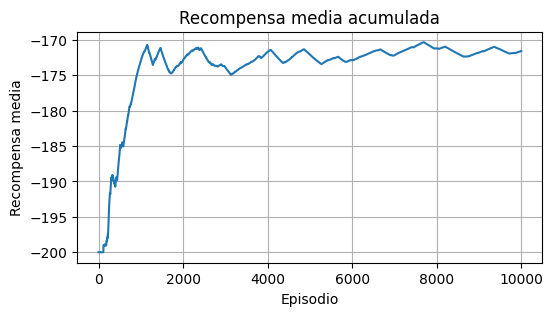

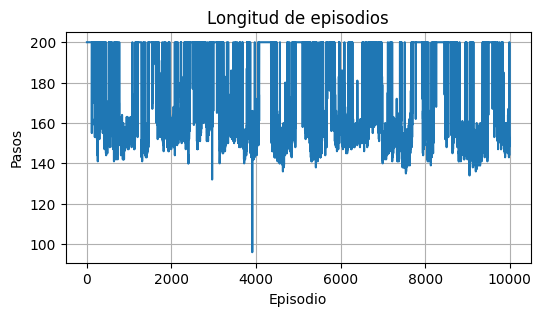

In [59]:
mostrar_resultados_agente_continuo(agente)

In [60]:
evaluar_politica(agente, num_episodios=10000)

📊 Resultados de evaluación:
  Episodios evaluados: 10000
  Recompensa media:    -145.76 ± 16.38
  Recompensa min/max:  -88.00 / -189.00
  Episodios exitosos:  10000
  Episodios fallidos:  0
  Semillas fallidas: []


In [30]:
def grabar_video_agente(agente, seed, nombre_archivo="video_mountaincar.gif", fps=30):
    """
    Ejecuta un episodio con la política aprendida y guarda un video del entorno.
    """

    random.seed(seed)
    np.random.seed(seed)

    # Crear entorno con renderizado de imágenes
    env = gym.make("MountainCar-v0", render_mode="rgb_array")
    state, _ = env.reset(seed=seed)
    done = False
    total_reward = 0
    frames = []

    while not done:
        frame = env.render()
        frames.append(frame)

        action = agente.seleccionar_accion_greedy(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            break

    env.close()

    print(f"Número total de frames: {len(frames)}")
    # Guardar el video como GIF
    imageio.mimsave(nombre_archivo, frames, fps=fps, loop=0)
    print(f"🎥 Vídeo guardado en: {nombre_archivo}")
    print(f"🏁 Recompensa total obtenida: {total_reward:.2f}")

In [34]:
nombre_archivo = "video_mountaincar_tile_coding.gif"

grabar_video_agente(agente, seed=7077, nombre_archivo=nombre_archivo)

HTML(f"""
<img src="{nombre_archivo}" style="width: 600px;" loop>
""")

Número total de frames: 200
🎥 Vídeo guardado en: video_mountaincar_tile_coding.gif
🏁 Recompensa total obtenida: -200.00
